In [1]:
import random
import numpy as np
from matplotlib import pyplot as plt
import tifffile as tiff
import glob
import os
import cv2
import tensorflow as tf
from tensorflow.python.client import device_lib
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda, Activation, MaxPool2D, Concatenate
from keras import optimizers
from keras.optimizers import Adam
from keras.metrics import MeanIoU
from keras import backend as K
from sklearn import metrics
# from google.colab import drive

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from skimage.filters import threshold_otsu, threshold_multiotsu
from cv2 import adaptiveThreshold

2024-05-13 18:32:08.672869: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-13 18:32:08.672986: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-13 18:32:08.858327: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [9]:

kernel_initializer =  'he_uniform'  # also try 'he' but model not converging...

def conv_block(inputs, filter_count, pool=True, batchnorm = True):

    #first layer
    x = Conv2D(filter_count, 3, padding = 'same', kernel_initializer = 'he_uniform')(inputs)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)

    #second layer
    x = Conv2D(filter_count, 3, padding = 'same', kernel_initializer = 'he_uniform')(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)

    if pool == True:
        p = MaxPool2D((2, 2))(x)
        return x, p
    else:
        return x



def deconv_block(inputs, concat_layer, filter_count, pool = False):
    u = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(inputs)
    c = Concatenate()([u, concat_layer])
    x = conv_block(c, filter_count, pool = pool, batchnorm = True)
    return u, c, x

def make_me_a_unet(shape, num_classes):

    inputs = Input(shape) # 768 x 1152

    # Downsampling side of the UNET i.e. the encoder !

    x1, p1 = conv_block(inputs, 16, pool=True, batchnorm=True)
    x2, p2 = conv_block(p1, 32, pool=True, batchnorm=True)
    x3, p3 = conv_block(p2, 64, pool=True, batchnorm=True)
    x4, p4 = conv_block(p3, 128, pool=True, batchnorm=True)
    b = conv_block(p4, 256, pool=False, batchnorm=True)

    # Upsampling side of the UNET i.e the decoder !

    u1, c1, x5 = deconv_block(b, x4, 128)
    u2, c2, x6 = deconv_block(x5, x3, 64)
    u3, c3, x7 = deconv_block(x6, x2, 32)
    u4, c4, x8 = deconv_block(x7, x1, 16)

    # The output layer

    output = Conv2D(num_classes, 1, padding='same', activation='sigmoid')(x8)

    #softmax for multiclass classification, num_classes = 23 !

    return Model(inputs, output)




model = make_me_a_unet((IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS), 1)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        448 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │         64 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      2,320 │ activation[0][0]  │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │         64 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │      9,248 │ activation_2[0][… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_4[0][0]  

 Total params: 1,642,177 (6.26 MB)

 Trainable params: 1,639,233 (6.25 MB)

 Non-trainable params: 2,944 (11.50 KB)

493


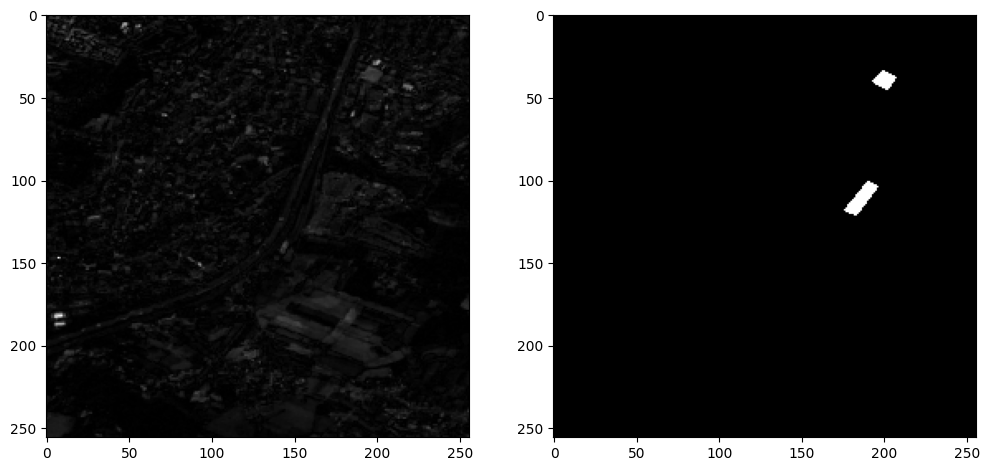

In [10]:
image_number = random.randint(0, len(X_train))
print(image_number)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(X_train[image_number], (256, 256,3)), cmap='gray')
plt.subplot(122)
plt.imshow(np.reshape(y_train[image_number], (256, 256)), cmap='gray')
plt.show()

In [11]:


%%time
seed=24

img_data_gen_args = dict(rotation_range=90,
                     width_shift_range=0.3,
                     height_shift_range=0.3,
                     horizontal_flip=True,
                     vertical_flip=True,
                     shear_range=0.5,
                     fill_mode='reflect')

mask_data_gen_args = dict(rotation_range=90,
                     width_shift_range=0.3,
                     height_shift_range=0.3,
                     horizontal_flip=True,
                     vertical_flip=True,
                     shear_range=0.5,
                     fill_mode='reflect',
                     preprocessing_function = lambda x: np.where(x>0, 1, 0).astype(x.dtype)) #Binarize the output again.
X_train=X_train.reshape(582, 256, 256, 3)
X_test=X_test.reshape(195, 256, 256, 3)
image_data_generator = ImageDataGenerator(**img_data_gen_args)
image_data_generator.fit(X_train, augment=True, seed=seed)
image_generator = image_data_generator.flow(X_train, seed=seed)
valid_img_generator = image_data_generator.flow(X_test, seed=seed)

CPU times: user 7.61 s, sys: 303 ms, total: 7.91 s
Wall time: 7.91 s


In [12]:
%%time

mask_data_generator = ImageDataGenerator(**mask_data_gen_args)
mask_data_generator.fit(y_train, augment=True, seed=seed)
mask_generator = mask_data_generator.flow(y_train, seed=seed)
valid_mask_generator = mask_data_generator.flow(y_test, seed=seed)

CPU times: user 2.53 s, sys: 90.3 ms, total: 2.62 s
Wall time: 2.62 s


In [13]:
def my_image_mask_generator(image_generator, mask_generator):
    train_generator = zip(image_generator, mask_generator)
    for (img, mask) in train_generator:
        yield (img, mask)

my_generator = my_image_mask_generator(image_generator, mask_generator)

validation_datagen = my_image_mask_generator(valid_img_generator, valid_mask_generator)



In [ ]:


%%time
# model = get_model()
from tensorflow import keras
#@title Select parameters {run: "auto"}

optimizer = 'nag' #@param ["adam" , "momentum" , "rmsprop" , "adagrad", "nag"] {type :"string"}
Learning_rate = 0.01 #@param {type:"number"}
LR = float(Learning_rate)
if (optimizer=="adagrad"):
  opt = keras.optimizers.Adagrad(learning_rate=LR)
if (optimizer=="adam"):
  opt = keras.optimizers.Adam(learning_rate=LR)
if (optimizer=="RMSprop"):
  opt = keras.optimizers.RMSProp(learning_rate=LR)
if (optimizer=="momentum"):
  opt = keras.optimizers.SGD(learning_rate=LR,momentum=0.9)
if (optimizer=="nag"):
  opt = keras.optimizers.SGD(learning_rate=LR,momentum=0.9,nesterov=True)

batch_size = 64
steps_per_epoch = 3*(len(X_train))//batch_size
model.compile(optimizer= opt, loss= 'binary_crossentropy', metrics=['acc'])
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)
history = model.fit(my_generator,
                    validation_data = validation_datagen,
                    steps_per_epoch = steps_per_epoch,
                    validation_steps = steps_per_epoch,
                    epochs=200)

Epoch 1/200


I0000 00:00:1715625219.424446     103 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


27/27 ━━━━━━━━━━━━━━━━━━━━ 103s 2s/step - acc: 0.6353 - loss: 0.7121 - val_acc: 0.9716 - val_loss: 0.3271
Epoch 2/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 24s 928ms/step - acc: 0.9630 - loss: 0.2029 - val_acc: 0.9725 - val_loss: 0.1976
Epoch 3/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 21s 782ms/step - acc: 0.9669 - loss: 0.1555 - val_acc: 0.9725 - val_loss: 0.1559
Epoch 4/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 15s 577ms/step - acc: 0.9713 - loss: 0.1390 - val_acc: 0.9726 - val_loss: 0.1392
Epoch 5/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 17s 627ms/step - acc: 0.9717 - loss: 0.1341 - val_acc: 0.9727 - val_loss: 0.1317
Epoch 6/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 15s 554ms/step - acc: 0.9703 - loss: 0.1382 - val_acc: 0.9722 - val_loss: 0.1300
Epoch 7/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 16s 608ms/step - acc: 0.9689 - loss: 0.1418 - val_acc: 0.9724 - val_loss: 0.1282
Epoch 8/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 17s 639ms/step - acc: 0.9699 - loss: 0.1385 - val_acc: 0.9732 - val_loss: 0.1247
Epoch 9/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 17s 653ms/step 

In [ ]:
#plot the training and validation accuracy and loss at each epoch
# batch_size*steps_per_epoch*len(loss)
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
# test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img, 0)
print(test_img_number)
prediction = model.predict(test_img_input)
prediction = prediction> threshold_otsu(prediction)
prediction=prediction[0,:,:,0]
plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()